# $\textbf{E}\times\textbf{B}$ Drift

In [1]:
# Add zpic library to path
import sys
sys.path.append("../../lib")

# get ZPIC 2D
import em2d as zpic
import numpy as np

#get packages to draw the plots
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec

from scipy import ndimage, datasets


# Time step
dt = 0.01

# Simulation time
tmax = 22.8

# Number of cells
nx  = [64,64]

# Simulation box size
box = [6,6]


## Plasma slabs
# Particles per cell
ppc = [4,4]

def custom_n0(x):
    if (x>1.2 and x<1.4):
        return 1.0
    else:
        return 0.0

# Use a custom density profile
dens = zpic.Density( type = "custom", custom_x = custom_n0,custom_y = custom_n0  )

# Set up a super low density so we are basically tracking a particle
dens.n=1e-6

# give it a small velocity to kick of the motion
ufl=0.1

#create the species
electrons = zpic.Species( "electrons", m_q=-1,ppc= ppc, density = dens,ufl=[ufl,0,0])

# If we want a positive charge particle, we need to repeat the above steps
dens2=zpic.Density( type = "custom", custom_x = custom_n0,custom_y = custom_n0  )

dens2.n=1e-6

positives = zpic.Species( "positrons", m_q=2, ppc=ppc, density = dens2,ufl=[ufl,0,0])


# Initializing simulation
sim = zpic.Simulation( nx, box, dt, species = (electrons,positives) )

#Set the sorting period to 0 in order to track the particle's trajectories 
#(this must be done after initilializng the simulation object)

positives.n_sort=0
electrons.n_sort=0

#Setup the external fields 

B=[0,0,1]
E=[0,0.01,0]

ext = zpic.ExternalField(B_type = 'uniform', B_0 = B,E_type = 'uniform', E_0 = E) 

sim.emf.set_ext_fld( ext )

#arays to store the particles trajectories
pos_part_rep =[]
ele_part_rep =[]


while sim.t < 16*np.pi:
    print('n = {:d}, t = {:g}'.format(sim.n,sim.t), end = '\r')
    #store the electron trajectories
    ele_part_rep.append(electrons.particles[40].copy())
    #store the positron(ish) trajectories
    pos_part_rep.append(positives.particles[40].copy())

    sim.iter()


In [2]:
#convert trajectories to position arrays
e_posx_t=[(i['ix']+i['x'])*box[0]/nx[0] for i in ele_part_rep]
e_posy_t=[(i['iy']+i['y'])*box[1]/nx[1] for i in ele_part_rep]

p_posx_t=[(i['ix']+i['x'])*box[0]/nx[0] for i in pos_part_rep]
p_posy_t=[(i['iy']+i['y'])*box[1]/nx[1] for i in pos_part_rep]

#create time array
t=np.linspace(0,sim.t,sim.n)

In [3]:
e_vx_t=[(i['ux']) for i in ele_part_rep]
e_vy_t=[(i['uy']) for i in ele_part_rep]


p_vx_t=[(i['ux']) for i in pos_part_rep]
p_vy_t=[(i['uy']) for i in pos_part_rep]

#Theoretical trajectories
e_posx_theoretical=[(E[1]/B[2])*t[i] + e_posx_t[0] for i in range(len(t))]


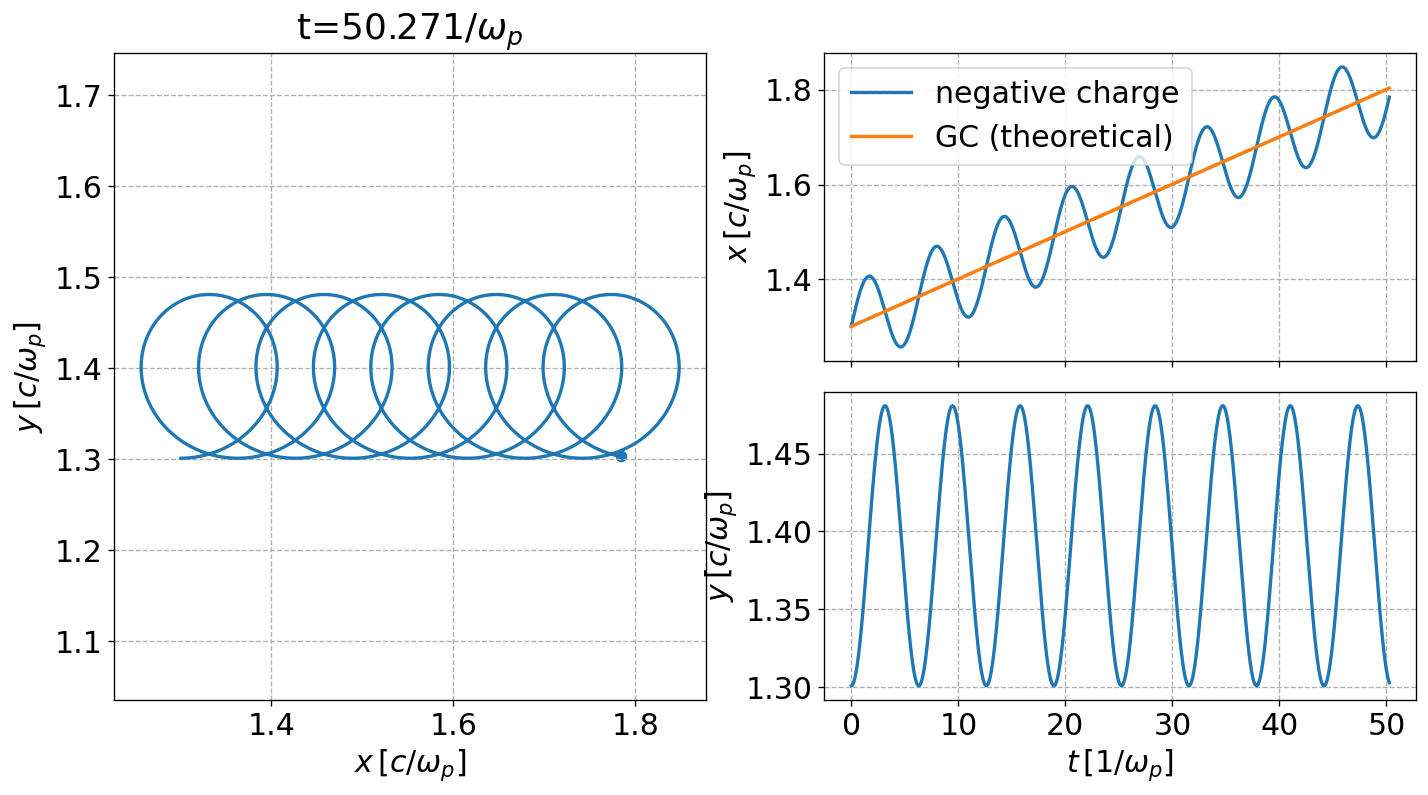

In [4]:
#Set up the plot
fig=plt.figure(figsize=(14, 7), dpi=120)
plt.rcParams.update({'font.size': 18})
gs2 = gridspec.GridSpec(2, 2, hspace=0.1,width_ratios=[2, 2])

#left part: xy trajectories 
ax = plt.subplot(gs2[:, 0])
## negative charge trajectory
ax.plot(e_posx_t,e_posy_t,lw=2)
ax.scatter(e_posx_t[-1],e_posy_t[-1])

#top right: xt trajectories
ax2 = plt.subplot(gs2[0,1])
ax2.plot(t,E[1]/B[2]*t+(p_posx_t[0]+e_posx_t[0])/2,lw=2,c='k',ls='--',alpha=0.4)
ax2.plot(t,e_posx_t,lw=2,label="negative charge")
ax2.plot(t, e_posx_theoretical,lw=2, label = "GC (theoretical)" )

#bottom right: yt trajectories
ax3 = plt.subplot(gs2[1,1])
ax3.plot(t,e_posy_t,lw=2)

##setup labels, grids, and others
ax.grid(True,ls="--")
ax.set_xlabel("$x\,[c/\omega_p]$")
ax.set_ylabel("$y\,[c/\omega_p]$")
ax.set_aspect('equal', 'datalim')
ax.set_title("t={:.2f}$1/\omega_p$".format(sim.t))

ax2.set_xticklabels([])
ax2.grid(True,ls="--")
ax2.set_ylabel("$x\,[c/\omega_p]$")
ax2.legend()

ax3.set_ylabel("$y\,[c/\omega_p]$")
ax3.set_xlabel("$t\,[1/\omega_p]$")
ax3.grid(True,ls="--")

plt.show()

# $\nabla \textbf{B}$ Drift

In [5]:
# Time step
dt = 0.01

# Simulation time
tmax = 20

# Number of cells
nx  = [64,64]

# Simulation box size
box = [6,6]

m_q = -1 #mass over charge ratio

# Plasma slabs
# Particles per cell
ppc = [4,4]

def custom_n0(x):
    if (x>1.2 and x<1.4):
        return 1.0
    else:
        return 0.0

# Use a custom density profile
dens = zpic.Density( type = "custom", custom_x = custom_n0,custom_y = custom_n0  )
# Set up a super low density
dens.n=1e-6
# give it a small velocity to kick of the motion
ufl=0.1
#create the species
electrons = zpic.Species( "electrons", m_q=-1,ppc= ppc,
                           density = dens,ufl=[ufl,0,0])

## Positive charge
dens2=zpic.Density( type = "custom", custom_x = custom_n0, custom_y = custom_n0  )
dens2.n=1e-6
positives = zpic.Species( "positrons", m_q=2, ppc=ppc,
                           density = dens2,ufl=[ufl,0,0])


# Initialize simulation
sim = zpic.Simulation( nx, box, dt, species = (electrons,positives) )

#Set the sorting period to 0 in order to track the particle's trajectories 
#(this must be done after initilializng the simulation object)
positives.n_sort=0
electrons.n_sort=0

#Setup the external fields (Remenber that they must be perpendicular)
# B=[0,0,1]

def extB(ix,dx,iy,dy):
    x0 = 0
    y0 = 0
 
    x = ix*dx - x0
    y = (iy+0.5)*dy - y0

    bz = x
    return [0,0,bz] 

E=[0,0,0]

gradB = np.gradient(B)
print(gradB)

ext = zpic.ExternalField(B_type = 'custom', B_custom = extB, E_type = 'uniform', E_0 = E)

sim.emf.set_ext_fld( ext )



#arays to store the particles trajectories
pos_part_rep =[]
ele_part_rep =[]


while sim.t < 16*np.pi:
    print('n = {:d}, t = {:g}'.format(sim.n,sim.t), end = '\r')
    #store the electron trajectories
    ele_part_rep.append(electrons.particles[40].copy())
    #store the positron(ish) trajectories
    pos_part_rep.append(positives.particles[40].copy())

    sim.iter()

[0.  0.5 1. ]


In [6]:
#convert trajectories to position arrays
e_posx_t=[(i['ix']+i['x'])*box[0]/nx[0] for i in ele_part_rep]
e_posy_t=[(i['iy']+i['y'])*box[1]/nx[1] for i in ele_part_rep]

p_posx_t=[(i['ix']+i['x'])*box[0]/nx[0] for i in pos_part_rep]
p_posy_t=[(i['iy']+i['y'])*box[1]/nx[1] for i in pos_part_rep]

#create time array
t=np.linspace(0,sim.t,sim.n)



In [7]:
e_vx_t=[(i['ux']) for i in ele_part_rep]
e_vy_t=[(i['uy']) for i in ele_part_rep]


p_vx_t=[(i['ux']) for i in pos_part_rep]
p_vy_t=[(i['uy']) for i in pos_part_rep]    

modBsquared = B[0]*B[0] + B[1]*B[1] + B[2]*B[2]

perpvelocity = np.asarray(e_vx_t)

perpvelocity_y = np.asarray(e_vy_t)

rl = m_q * perpvelocity / np.sqrt(modBsquared) #Larmour radius
rl_y = m_q * perpvelocity_y / np.sqrt(modBsquared) #Larmour radius

larmour = np.asarray(rl)

larmour_y = np.asarray(rl_y)

cross = np.cross(B, gradB)

modcross = cross[0]*cross[0] + cross[1]*cross[1] + cross[2]*cross[2]


#Theoretical GC trajectory for electrons
e_posx_theoretical=(0.5 * perpvelocity[:] * larmour[:] * modcross/ modBsquared) *t[:] + e_posx_t[0]
e_posy_theoretical=(0.5 * perpvelocity_y[:] * larmour_y[:] * modcross/ modBsquared) *t[:] + e_posy_t[0]

# e_posx_theoretical=(0.5 * (perpvelocity[:] + perpvelocity_y[:]) * larmour[:] * modcross/ modBsquared) *t[:] + e_posx_t[0]
# e_posy_theoretical=(0.5 * (perpvelocity_y[:] + perpvelocity[:]) * larmour_y[:] * modcross/ modBsquared) *t[:] + e_posy_t[0]

# e_posx_theoretical = (0.5 * (m_q / np.sqrt(modBsquared)) * np.linalg.norm(perpvelocity) * np.linalg.norm(perpvelocity) * modcross/ modBsquared)* t + e_posx_t[0]
# e_posy_theoretical = (0.5 * (m_q / np.sqrt(modBsquared)) * np.linalg.norm(perpvelocity_y) * np.linalg.norm(perpvelocity_y) * modcross/ modBsquared)* t + e_posy_t[0]

# e_posx_theoretical=(0.5 * np.linalg.norm(perpvelocity[:] * larmour[:]) * modcross/ modBsquared) *t[:] + e_posx_t[0]
# e_posy_theoretical=(0.5 * np.linalg.norm(perpvelocity_y[:] * larmour_y[:]) * modcross/ modBsquared) *t[:] + e_posy_t[0]

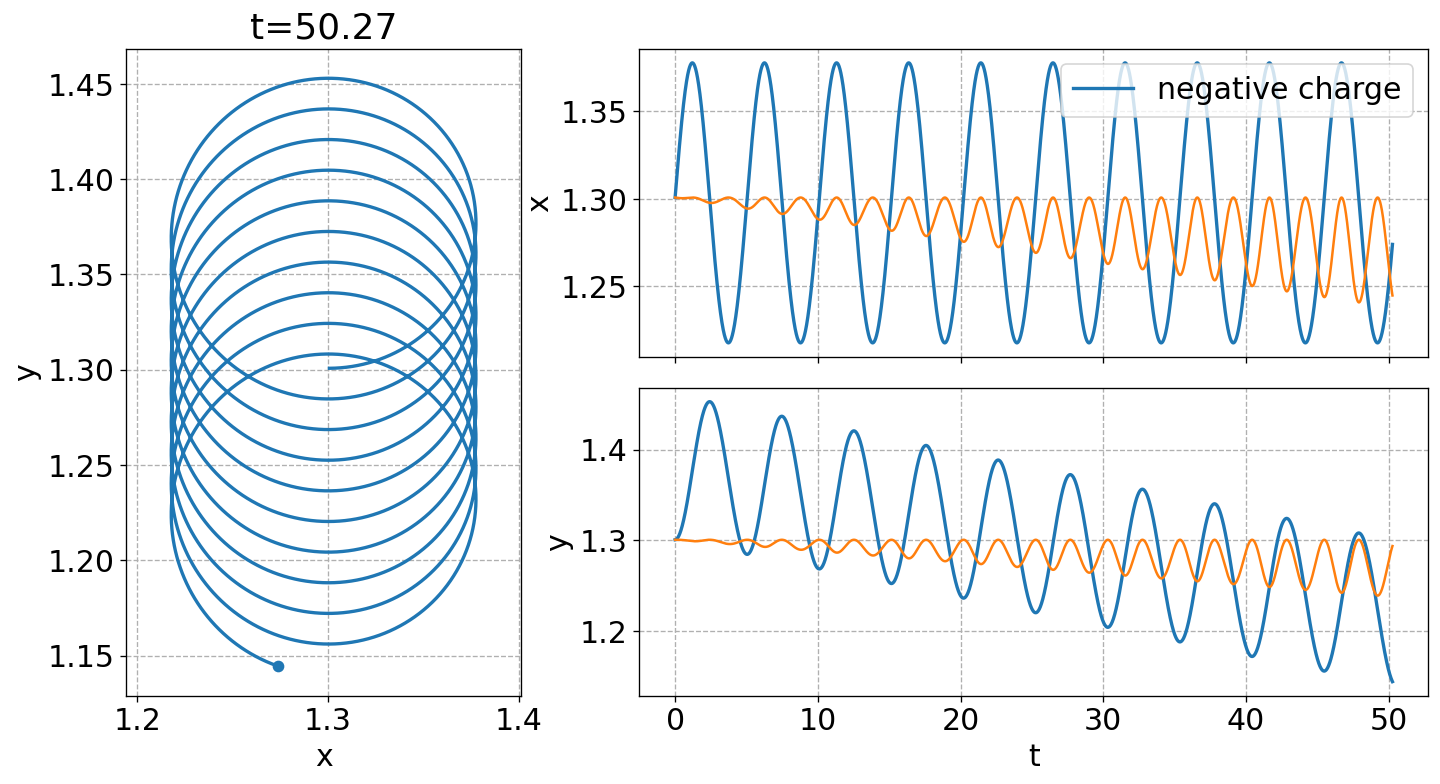

In [8]:
#Set up the plot
fig=plt.figure(figsize=(14, 7), dpi=120)
plt.rcParams.update({'font.size': 18})
gs2 = gridspec.GridSpec(2, 2, hspace=0.1,width_ratios=[1, 2])

#left part: xy trajectories
ax = plt.subplot(gs2[:, 0])
# negative charge trajectory
ax.plot(e_posx_t,e_posy_t,lw=2)
ax.scatter(e_posx_t[-1],e_posy_t[-1])

#top right: xt trajectories
ax2 = plt.subplot(gs2[0,1])
ax2.plot(t,e_posx_t,lw=2,label="negative charge")
ax2.plot(t, e_posx_theoretical)

#bottom right: yt trajectories
ax3 = plt.subplot(gs2[1,1])
ax3.plot(t,e_posy_t,lw=2)
ax3.plot(t, e_posy_theoretical)

##setup labels, grids, and others
ax.grid(True,ls="--")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect('equal', 'datalim')
ax.set_title("t={:.2f}".format(sim.t))

ax2.set_xticklabels([])
ax2.grid(True,ls="--")
ax2.set_ylabel("x")
ax2.legend()

ax3.set_ylabel("y")
ax3.set_xlabel("t")
ax3.grid(True,ls="--")

plt.show()


# Diamagnetic Drift - $\nabla n(\textbf{x})$

In [9]:
# Time step
dt = 0.01

# Simulation time
tmax = 22.8

# Number of cells
nx  = [64,64]

# Simulation box size
box = [6,6]

m_q = -1 #mass over charge ratio

## Plasma slabs
# Particles per cell
ppc = [4,4]
    
#density gradient
def custom_nx(x):
    return 1+2*x if (x>0.25 and x<1.25) else 0.0
def custom_ny(x):
    return 1 if (x>0.25 and x<1.25) else  0.0

# Use a custom density profile
dens = zpic.Density( type = "custom", custom_x = custom_nx,custom_y = custom_ny  )

# Set up a super low density
dens.n=1e-6
# give it a small velocity to kick of the motion
ufl=0.1
#create the species
electrons = zpic.Species( "electrons", m_q=-1,ppc= ppc,
                           density = dens,ufl=[ufl,0,0])

## Positive charge
dens2=zpic.Density( type = "custom", custom_x = custom_n0, custom_y = custom_n0  )
dens2.n=1e-6
positives = zpic.Species( "positrons", m_q=2, ppc=ppc,
                           density = dens2,ufl=[ufl,0,0])


# Initialize simulation
sim = zpic.Simulation( nx, box, dt, species = (electrons,positives) )

#Set the sorting period to 0 in order to track the particle's trajectories 
#(this must be done after initilializng the simulation object)
positives.n_sort=0
electrons.n_sort=0

#Setup the external fields (Remenber that they must be perpendicular)
# B=[0,0,1]

B=[0,0,1]
modB = np.sqrt(B[0]*B[0] + B[1]*B[1] + B[2]*B[2])

ext = zpic.ExternalField(B_type = 'uniform', B_0 = B,E_type = 'none')

sim.emf.set_ext_fld( ext )



#arays to store the particles trajectories
pos_part_rep =[]
ele_part_rep =[]


while sim.t < 16*np.pi:
    print('n = {:d}, t = {:g}'.format(sim.n,sim.t), end = '\r')
    #store the electron trajectories
    ele_part_rep.append(electrons.particles[40].copy())
    #store the positron(ish) trajectories
    pos_part_rep.append(positives.particles[40].copy())

    sim.iter()

In [10]:
#convert trajectories to position arrays
e_posx_t=[(i['ix']+i['x'])*box[0]/nx[0] for i in ele_part_rep]
e_posy_t=[(i['iy']+i['y'])*box[1]/nx[1] for i in ele_part_rep]

p_posx_t=[(i['ix']+i['x'])*box[0]/nx[0] for i in pos_part_rep]
p_posy_t=[(i['iy']+i['y'])*box[1]/nx[1] for i in pos_part_rep]

#create time array
t=np.linspace(0,sim.t,sim.n)

In [11]:
e_vx_t=[(i['ux']) for i in ele_part_rep]
e_vy_t=[(i['uy']) for i in ele_part_rep]


p_vx_t=[(i['ux']) for i in pos_part_rep]
p_vy_t=[(i['uy']) for i in pos_part_rep]


uth = 0.3 #termal velocity

#x = np.linspace(0.25, 1.25, 12)
x = np.linspace(0.25, 1.25, len(t))


denss = 1 + 2 * x
densemy = np.ones_like(denss)

gradn = [denss[:], densemy[:]]

# vector of denss and densemy

print(gradn)

#Theoretical guiding center trajectory
# e_posx_theoretical = - (2 * uth * m_q / (modB * np.linalg.norm(denss[:]))) * t + e_posx_t[0]
e_posy_theoretical = (2 * uth**2 * m_q / (modB * np.linalg.norm(gradn[:]))) * t[:] + e_posy_t[0]


[array([1.5       , 1.50039793, 1.50079586, ..., 3.49920414, 3.49960207,
       3.5       ]), array([1., 1., 1., ..., 1., 1., 1.])]


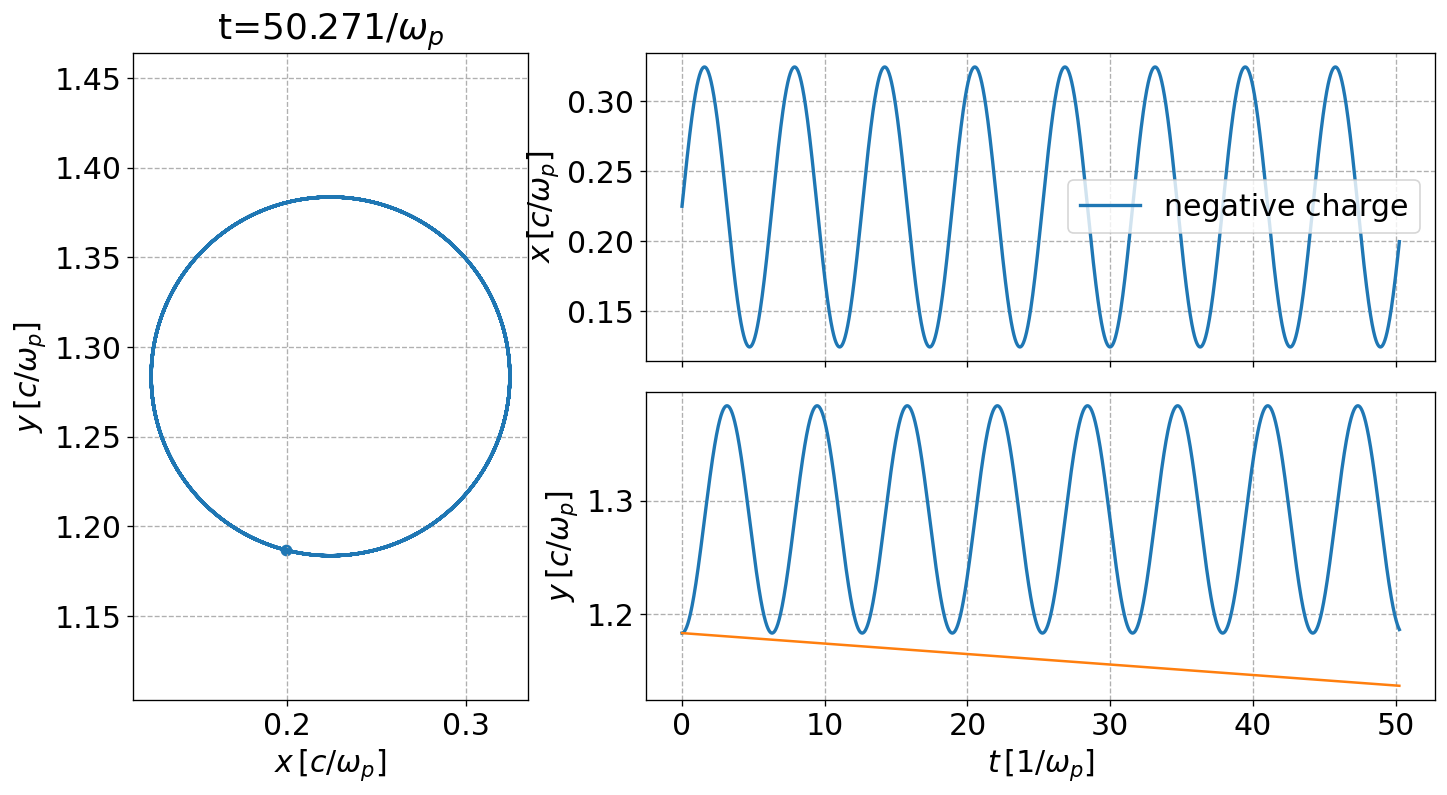

In [12]:
#Set up the plot
fig=plt.figure(figsize=(14, 7), dpi=120)
plt.rcParams.update({'font.size': 18})
gs2 = gridspec.GridSpec(2, 2, hspace=0.1,width_ratios=[1, 2])

#left part: xy trajectories
ax = plt.subplot(gs2[:, 0])
## negative charge trajectory
ax.plot(e_posx_t,e_posy_t,lw=2)
ax.scatter(e_posx_t[-1],e_posy_t[-1])

#top right: xt trajectories
ax2 = plt.subplot(gs2[0,1])
ax2.plot(t,e_posx_t,lw=2,label="negative charge")

#bottom right: yt trajectories
ax3 = plt.subplot(gs2[1,1])
ax3.plot(t,e_posy_t,lw=2)
ax3.plot(t, e_posy_theoretical, label  = "GC (theoretical)")


##setup labels, grids, and others
ax.grid(True,ls="--")
ax.set_xlabel("$x\,[c/\omega_p]$")
ax.set_ylabel("$y\,[c/\omega_p]$")
ax.set_aspect('equal', 'datalim')
ax.set_title("t={:.2f}$1/\omega_p$".format(sim.t))

ax2.set_xticklabels([])
ax2.grid(True,ls="--")
ax2.set_ylabel("$x\,[c/\omega_p]$")
ax2.legend()

ax3.set_ylabel("$y\,[c/\omega_p]$")
ax3.set_xlabel("$t\,[1/\omega_p]$")
ax3.grid(True,ls="--")

plt.show()

# Non Uniform E field

In [13]:
# Time step
dt = 0.01

# Simulation time
tmax = 22.8

# Number of cells
nx  = [192,192]

# Simulation box size
box = [18,18]


## Plasma slabs
# Particles per cell
ppc = [4,4]

def custom_n0(x):
    if (x>1.2 and x<1.4):
        return 1.0
    else:
        return 0.0

# Use a custom density profile
dens = zpic.Density( type = "custom", custom_x = custom_n0,custom_y = custom_n0  )
# Set up a super low density
dens.n=1e-6
# give it a small velocity to kick of the motion
ufl=0.1
#create the species
electrons = zpic.Species( "electrons", m_q=-1,ppc= ppc,
                           density = dens,ufl=[ufl,0,0])

## Positive charge
dens2=zpic.Density( type = "custom", custom_x = custom_n0, custom_y = custom_n0  )
dens2.n=1e-6
positives = zpic.Species( "positrons", m_q=2, ppc=ppc,
                           density = dens2,ufl=[ufl,0,0])


# Initialize simulation
sim = zpic.Simulation( nx, box, dt, species = (electrons,positives) )

#Set the sorting period to 0 in order to track the particle's trajectories 
#(this must be done after initilializng the simulation object)
positives.n_sort=0
electrons.n_sort=0

#Setup the external fields (Remenber that they must be perpendicular)
# B=[0,0,1]

def extE(ix,dx,iy,dy):
    x0 = 0
    y0 = 0
 
    x = ix*dx - x0
    y = (iy+0.5)*dy - y0

    ey =  0.01 * x
    return [0,ey,0] 

B = [0,0,1] 

ext = zpic.ExternalField(B_type = 'uniform', B_0 = B, E_type = 'custom', E_custom = extE)

sim.emf.set_ext_fld( ext )

#arays to store the particles trajectories
pos_part_rep =[]
ele_part_rep =[]


while sim.t < 16*np.pi:
    print('n = {:d}, t = {:g}'.format(sim.n,sim.t), end = '\r')
    #store the electron trajectories
    ele_part_rep.append(electrons.particles[40].copy())
    #store the positron(ish) trajectories
    pos_part_rep.append(positives.particles[40].copy())

    sim.iter()

In [14]:
#convert trajectories to position arrays
e_posx_t=[(i['ix']+i['x'])*box[0]/nx[0] for i in ele_part_rep]
e_posy_t=[(i['iy']+i['y'])*box[1]/nx[1] for i in ele_part_rep]

p_posx_t=[(i['ix']+i['x'])*box[0]/nx[0] for i in pos_part_rep]
p_posy_t=[(i['iy']+i['y'])*box[1]/nx[1] for i in pos_part_rep]

#create time array
t=np.linspace(0,sim.t,sim.n)

In [15]:
e_vx_t=[(i['ux']) for i in ele_part_rep]
e_vy_t=[(i['uy']) for i in ele_part_rep]


p_vx_t=[(i['ux']) for i in pos_part_rep]
p_vy_t=[(i['uy']) for i in pos_part_rep]

modBsquared = B[0]*B[0] + B[1]*B[1] + B[2]*B[2]

# paralelvelocity = np.asarray(e_vx_t)
# paralelvelocity_y = np.asarray(e_vx_t)

# rl = m_q * paralelvelocity / np.sqrt(modBsquared) #Larmour radius
# rl_y = m_q * paralelvelocity_y / np.sqrt(modBsquared) #Larmour radius

#using initial v_perp and initial rl

paralelvelocity = np.asarray(e_vx_t)
paralelvelocity_y = np.asarray(e_vx_t)

rl = m_q * paralelvelocity[0] / np.sqrt(modBsquared) #Larmour radius
rl_y = m_q * paralelvelocity_y[0] / np.sqrt(modBsquared) #Larmour radius

larmour = np.asarray(rl)
larmour_y = np.asarray(rl_y)

modlarmour = np.linalg.norm(larmour)

cross = np.cross(E,B)

modcross = np.sqrt(cross[0]*cross[0] + cross[1]*cross[1] + cross[2]*cross[2])

#Theoretical trajectory for electrons

#e_posx_theoretical = (np.linalg.norm(cross/modBsquared)+ 0.25 * modlarmour**2 * np.linalg.norm(ndimage.laplace(cross/modBsquared)))* t + e_posx_t[0]
e_posx_theoretical =  (0.01 * np.asarray(e_posx_t)/modBsquared) * t + e_posx_t[0]
print(e_posx_theoretical)

[1.30078125 1.30091145 1.30104186 ... 2.37481515 2.37546992 2.37612546]


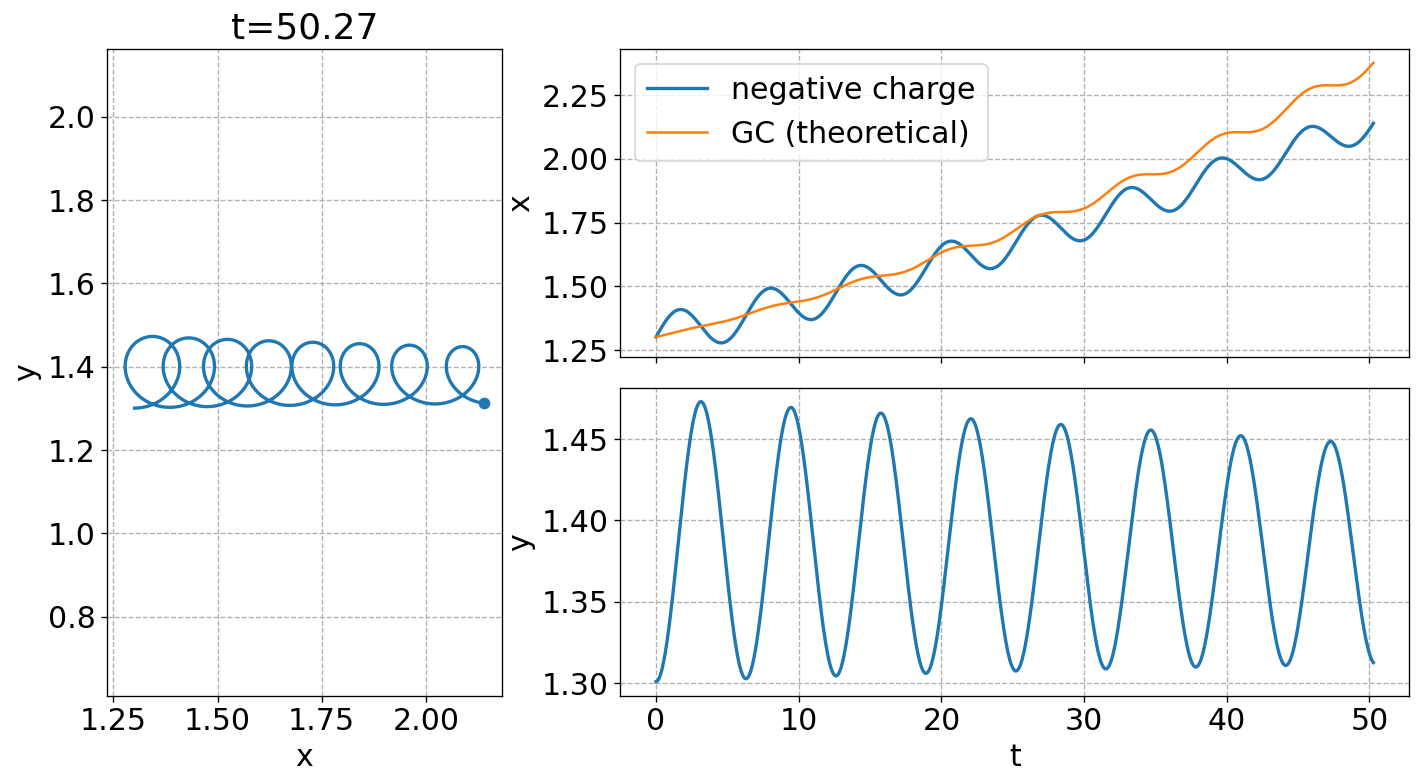

In [16]:
#Set up the plot
fig=plt.figure(figsize=(14, 7), dpi=120)
plt.rcParams.update({'font.size': 18})
gs2 = gridspec.GridSpec(2, 2, hspace=0.1,width_ratios=[1, 2])

#left part: xy trajectories
ax = plt.subplot(gs2[:, 0])
## negative charge trajectory
ax.plot(e_posx_t,e_posy_t,lw=2)
ax.scatter(e_posx_t[-1],e_posy_t[-1])

#top right: xt trajectories
ax2 = plt.subplot(gs2[0,1])
ax2.plot(t,e_posx_t,lw=2,label="negative charge")
ax2.plot(t, e_posx_theoretical, label = "GC (theoretical)" )

# range = [[0,sim.box[0]],[0,sim.box[1]]]

# plt.imshow( sim.emf.Ez_part, interpolation = 'bilinear', origin = 'lower',
#           extent = ( range[0][0], range[0][1], range[1][0], range[1][1] ),
#           aspect = 'auto', cmap = 'RdBu')

# plt.colorbar().set_label('$E_1$')
# plt.xlabel("$x_1$")
# plt.ylabel("$x_2$")
# plt.title("Accelerating Field\nt = {:g}".format(sim.t))

#bottom right: yt trajectories
ax3 = plt.subplot(gs2[1,1])
ax3.plot(t,e_posy_t,lw=2)

##setup labels, grids, and others
ax.grid(True,ls="--")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect('equal', 'datalim')
ax.set_title("t={:.2f}".format(sim.t))

ax2.set_xticklabels([])
ax2.grid(True,ls="--")
ax2.set_ylabel("x")
ax2.legend()

ax3.set_ylabel("y")
ax3.set_xlabel("t")
ax3.grid(True,ls="--")

plt.show()